# Assignment 5 - Text Analysis
An explanation this assignment could be found in the .pdf explanation document


## Materials to review for this assignment
<h4>From Moodle:</h4> 
<h5><u>Review the notebooks regarding the following python topics</u>:</h5>
<div class="alert alert-info">
&#x2714; <b>Working with strings</b> (tutorial notebook)<br/>
&#x2714; <b>Text Analysis</b> (tutorial notebook)<br/>
&#x2714; <b>Hebrew text analysis tools (tokenizer, wordnet)</b> (moodle example)<br/>
&#x2714; <b>(brief review) All previous notebooks</b><br/>
</div> 
<h5><u>Review the presentations regarding the following topics</u>:</h5>
<div class="alert alert-info">
&#x2714; <b>Text Analysis</b> (lecture presentation)<br/>
&#x2714; <b>(brief review) All other presentations</b><br/>
</div>

## Preceding Step - import modules (packages)
This step is necessary in order to use external modules (packages). <br/>

In [1]:
# --------------------------------------
import pandas as pd
import numpy as np
# --------------------------------------


# --------------------------------------
# ------------- visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# --------------------------------------


# ---------------------------------------
import sklearn
from sklearn import preprocessing, metrics, pipeline, model_selection, feature_extraction
from sklearn import naive_bayes, linear_model, svm, neural_network, neighbors, tree
from sklearn import decomposition, cluster

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# ---------------------------------------


# ----------------- output and visualizations:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
# show several prints in one cell. This will allow us to condence every trick in one cell.
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# ---------------------------------------


### Text analysis and String manipulation imports:

In [2]:
# --------------------------------------
# --------- Text analysis and Hebrew text analysis imports:
# vectorizers:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# regular expressions:
import re
# --------------------------------------

### Reading input files
Reading input files for train annotated corpus (raw text data) corpus and for the test corpus

In [3]:
train_filename = 'annotated_corpus_for_train.csv'
test_filename  = 'corpus_for_test.csv'
df_train = pd.read_csv(train_filename, index_col=None, encoding='utf-8')
df_test  = pd.read_csv(test_filename, index_col=None, encoding='utf-8')

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, average_precision_score
from sklearn.decomposition import TruncatedSVD  # dimensionality reduction for sparse matrices (better than PCA)
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


df_train.head(3)
df_train.shape

df_test.head(3)
df_test.shape


(323, 2)

### Your implementation:
Write your code solution in the following code-cells

<AxesSubplot:xlabel='gender', ylabel='Count'>

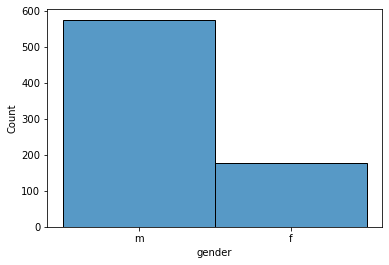

In [5]:
# Here we see our data is not well balanced , there are more males than females
sns.histplot(data=df_train,x="gender")

In [6]:
# Here we convert (f,m) to (1,0)
df_train['gender'] = df_train.apply(lambda row: 0 if row.gender == 'm' else 1, axis=1)


In [7]:
# Here we get some string as input , we clean it to get better results , and then we return it tokenized (split)
def my_tokenizer(txt):
    # remove numbers
    result = re.sub(r'\d', ' ', txt)
    # remove quatation marks
    result = re.sub(r'"', ' ', result)
    # remove dots
    result.replace(".", " ")
    # remove one letter words
    result = re.sub(r'\s\w\s', ' ', result)
    # remove redudant whitespace
    result = re.sub(r'\s+', ' ', result, flags=re.I)
    # remove 'ו' from the beginning of a word
    result = re.sub(r'\sו', ' ', result)
    # replace non-alphanumeric characters with whitespace
    result = re.sub(r'\W', ' ', result)
    return result.split()


In [8]:
# Split data to train and validation
X_train, X_val, y_train, y_val = train_test_split(df_train.story, df_train.gender, test_size=0.33, random_state=42)


In [9]:
class MyClassifier(sklearn.base.ClassifierMixin):
    # Used for dimensionality reduction.
    # First we do dim and only after we use the classifier
    def __init__(self, k):
        super().__init__()
        self.k = k
        self.dim_reduc_model = TruncatedSVD(k)
        self.classifier = GaussianNB(priors=[0.75, 0.25])

    def fit(self, X, y):
        self.dim_reduc_model.fit(X, y)
        X_transformed = self.dim_reduc_model.transform(X)
        self.classifier.fit(X_transformed, y)

    def predict(self, X):
        X_transformed = self.dim_reduc_model.transform(X)
        y_pred = self.classifier.predict(X_transformed)
        return y_pred

    def predict_proba(self, X):
        X_transformed = self.dim_reduc_model.transform(X)
        y_prob = self.classifier.predict_proba(X_transformed)
        return y_prob


In [10]:

def find_best_k(Ks):
    avg_f1_weighted_train_vec = []
    avg_f1_weighted_val_vec = []
    avg_f1_macro_train_vec = []
    avg_f1_macro_val_vec = []
    y_prob_train_vec = []
    y_prob_val_vec = []

    # Trying all the k's to see which one is optimal
    for k in Ks:
        my_classifier_k = MyClassifier(k)
        print("k=" + str(k))
        cf = Pipeline([('vect', TfidfVectorizer(tokenizer=my_tokenizer)), ('classifier', my_classifier_k)])
        cf.fit(X_train, y_train)
        y_pred_val = cf.predict(X_val)
        y_pred_train = cf.predict(X_train)
        y_prob_train = cf.predict_proba(X_train)[:, 1]
        y_prob_val = cf.predict_proba(X_val)[:, 1]

        acc_train = accuracy_score(y_train, y_pred_train)
        prec_train = precision_score(y_train, y_pred_train)
        recall_train = recall_score(y_train, y_pred_train)
        f1_train = f1_score(y_train, y_pred_train)
        avg_f1_macro_train = f1_score(y_train, y_pred_train, average="macro")
        avg_f1_weighted_train = f1_score(y_train, y_pred_train, average="weighted")
        acc_val = accuracy_score(y_train, y_pred_train)
        prec_val = precision_score(y_val, y_pred_val)
        recall_val = recall_score(y_val, y_pred_val)
        avg_f1_macro_val = f1_score(y_val, y_pred_val, average="macro")
        avg_f1_weighted_val = f1_score(y_val, y_pred_val, average="weighted")
        print("train: acc: {}, precision: {}, recall: {},"
              "avg_f1 (macro): {}, avg_f1 (weighted): {} ".format(round(acc_train, 3),
                                                                  round(prec_train, 3),
                                                                  round(recall_train, 3),
                                                                  round(avg_f1_macro_train, 3),
                                                                  round(avg_f1_weighted_train, 3)))

        print("validation: acc: {}, precision: {}, recall: {},"
              " avg_f1 (macro): {}, avg_f1 (weighted): {}".format(round(acc_val, 3),
                                                                  round(prec_val, 3),
                                                                  round(recall_val, 3),
                                                                  round(avg_f1_macro_val, 3),
                                                                  round(avg_f1_weighted_val, 3)))
        avg_f1_macro_train_vec.append(avg_f1_macro_train)
        avg_f1_weighted_train_vec.append(avg_f1_weighted_train)

        avg_f1_macro_val_vec.append(avg_f1_macro_val)
        avg_f1_weighted_val_vec.append(avg_f1_weighted_val)

        y_prob_train_vec.append(y_prob_train)
        y_prob_val_vec.append(y_prob_val)

    # After testing all K values , we plot all the results & which one gave the best score
    plt.figure()
    plt.suptitle(my_classifier_k.classifier.__class__.__name__)

    plt.subplot(2, 1, 1)
    plt.plot(Ks, avg_f1_macro_train_vec, ".-", label="train")
    plt.plot(Ks, avg_f1_macro_val_vec, ".-", label="val")
    argmax_val_ind_macro = np.argmax(avg_f1_macro_val_vec)
    # saving best K + best f1 using that K
    best_k_macro = Ks[argmax_val_ind_macro]
    best_f1_macro = avg_f1_macro_val_vec[argmax_val_ind_macro]

    # Adding to the plot the best K value
    plt.plot([best_k_macro], [best_f1_macro], marker="*", label="optimal")
    plt.text(best_k_macro, best_f1_macro,
             s="({}, {})".format(best_k_macro, round(best_f1_macro, 4)))
    plt.legend()
    plt.ylabel("avg f1 macro")
    plt.ylim((-0.05, 1.05))

    # Now doing the same thing for average="weighted"
    plt.subplot(2, 1, 2)
    plt.plot(Ks, avg_f1_weighted_train_vec, ".-", label="train")
    plt.plot(Ks, avg_f1_weighted_val_vec, ".-", label="val")
    argmax_val_ind_weighted = np.argmax(avg_f1_weighted_val_vec)
    best_k_weighted = Ks[argmax_val_ind_weighted]
    best_f1_weighted = avg_f1_weighted_val_vec[argmax_val_ind_weighted]
    plt.plot([best_k_weighted], [best_f1_weighted], marker="*", label="optimal")
    plt.text(best_k_weighted, best_f1_weighted,
             s="({}, {})".format(best_k_weighted, round(best_f1_weighted, 4)))
    plt.legend()
    plt.xlabel("k (dim reduces to)")
    plt.ylabel("avg f1 weighted")
    plt.ylim((-0.05, 1.05))
    plt.show()

    return best_k_weighted, best_f1_macro

k=10
train: acc: 0.742, precision: 0.424, recall: 0.207,avg_f1 (macro): 0.56, avg_f1 (weighted): 0.707 
validation: acc: 0.742, precision: 0.3, recall: 0.053, avg_f1 (macro): 0.474, avg_f1 (weighted): 0.682
k=50
train: acc: 0.76, precision: 0.5, recall: 0.347,avg_f1 (macro): 0.63, avg_f1 (weighted): 0.744 
validation: acc: 0.76, precision: 0.476, recall: 0.175, avg_f1 (macro): 0.559, avg_f1 (weighted): 0.723
k=100
train: acc: 0.821, precision: 0.667, recall: 0.512,avg_f1 (macro): 0.733, avg_f1 (weighted): 0.813 
validation: acc: 0.821, precision: 0.326, recall: 0.754, avg_f1 (macro): 0.561, avg_f1 (weighted): 0.618
k=150
train: acc: 0.857, precision: 0.738, recall: 0.628,avg_f1 (macro): 0.793, avg_f1 (weighted): 0.853 
validation: acc: 0.857, precision: 0.261, recall: 0.93, avg_f1 (macro): 0.38, avg_f1 (weighted): 0.365
k=200
train: acc: 0.903, precision: 0.816, recall: 0.769,avg_f1 (macro): 0.864, avg_f1 (weighted): 0.902 
validation: acc: 0.903, precision: 0.229, recall: 0.965, avg_f

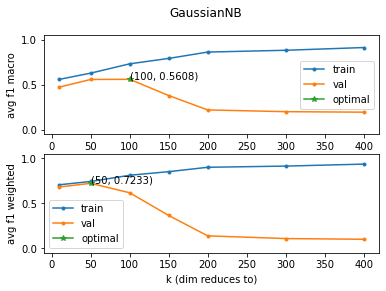

k=10
train: acc: 0.742, precision: 0.424, recall: 0.207,avg_f1 (macro): 0.56, avg_f1 (weighted): 0.707 
validation: acc: 0.742, precision: 0.2, recall: 0.018, avg_f1 (macro): 0.447, avg_f1 (weighted): 0.672
k=15
train: acc: 0.73, precision: 0.373, recall: 0.182,avg_f1 (macro): 0.54, avg_f1 (weighted): 0.694 
validation: acc: 0.73, precision: 0.4, recall: 0.035, avg_f1 (macro): 0.466, avg_f1 (weighted): 0.683
k=20
train: acc: 0.734, precision: 0.397, recall: 0.207,avg_f1 (macro): 0.555, avg_f1 (weighted): 0.702 
validation: acc: 0.734, precision: 0.5, recall: 0.053, avg_f1 (macro): 0.482, avg_f1 (weighted): 0.692
k=25
train: acc: 0.756, precision: 0.483, recall: 0.231,avg_f1 (macro): 0.582, avg_f1 (weighted): 0.722 
validation: acc: 0.756, precision: 0.4, recall: 0.035, avg_f1 (macro): 0.466, avg_f1 (weighted): 0.683
k=30
train: acc: 0.752, precision: 0.47, recall: 0.256,avg_f1 (macro): 0.59, avg_f1 (weighted): 0.724 
validation: acc: 0.752, precision: 0.4, recall: 0.035, avg_f1 (macro)

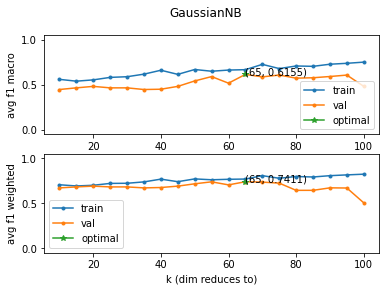





#############################################################################


In [11]:
Ks_gross_search = [10, 50, 100, 150, 200, 300, 400]
best_k_weighted, best_k_macro = find_best_k(Ks_gross_search)
best_k = best_k_weighted  # think it's preferred measurement in this case
before = Ks_gross_search[Ks_gross_search.index(best_k) - 1]
after = Ks_gross_search[Ks_gross_search.index(best_k) + 1]
step = 5

# in fine search we re-run the code with the index before best k , to the index after best k , with steps of 5
# for example if best k = 50 (pos[1]) , then : (pos[0]->pos[2]) ---> [10,15,20,25....95,100]

Ks_fine_search = list(range(before, after + 1, step))
best_k = find_best_k(Ks_fine_search)

print("\n\n\n\n#############################################################################")



In [12]:
print("The best value for K was :", best_k[0], "\n")
my_classifier_k = MyClassifier(best_k[0])
cf = Pipeline([('vect', TfidfVectorizer(tokenizer=my_tokenizer)), ('classifier', my_classifier_k)])
cf.fit(X_train, y_train)
y_pred_test = cf.predict(df_test.story)
print(pd.DataFrame({'y_train': df_test.story, 'y_pred': y_pred_test}).head(20))
print(pd.DataFrame({'y_train': df_test.story, 'y_pred': y_pred_test}).tail(20))

The best value for K was : 65 

                                              y_train  y_pred
0   כל קיץ אני והמשפחה נוסעים לארצות הברית לוס אנג...       0
1   הגעתי לשירות המדינה אחרי שנתיים כפעיל בתנועת "...       0
2   אחת האהבות הגדולות שלי אלו הכלבים שלי ושל אישת...       0
3   רגע הגיוס לצבא היה הרגע הכי משמעותי עבורי, אני...       0
4   אני הגעתי לברזיל ישר מקולומביה וגם אני עשיתי ע...       0
5   בפעם האחרונה שהייתי מחוץ לארץ ישראל הייתי באפר...       0
6   בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...       0
7   בנובמבר האחרון הייתי עם חברים בטיול ים אל ים, ...       0
8   לפני מספר חודשים, ביום שמש בהיר, קמתי בבוקר למ...       0
9   אני לא בן אדם שנוטה לשתף בחייו האישיים, אבל או...       0
10  לפני כמה זמן בדרך הביתה שמעתי איך כלבים נובחים...       0
11  חיכיתי לסוף שנת הלימודים הרבה מאוד זמן , כדי ל...       1
12  השנה, שנת הקורונה הייתה בשבילי שנה עם הרבה זמן...       0
13  החוויה שלי מתחילה במכון הטכנולוגי חולון, אשר ש...       0
14  לפני פחות משנה יחסית בתחילת התפשטו

### Save output to csv (optional)
After you're done save your output to the 'classification_results.csv' csv file.<br/>
We assume that the dataframe with your results contain the following columns:
* column 1 (left column): 'test_example_id'  - the same id associated to each of the test stories to be predicted.
* column 2 (right column): 'predicted_category' - the predicted gender value for each of the associated story. 

Assuming your predicted values are in the `df_predicted` dataframe, you should save you're results as following:

In [13]:
# df_predicted.to_csv('classification_results.csv',index=False)